In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import itertools

%matplotlib inline

In [2]:
# from ipyparallel import Client
# rc = Client()
# dview = rc[:]
# lview = rc.load_balanced_view()

# with rc[:].sync_imports():
#     import numpy
#     import pandas

## Load Data

In [3]:
train_data = pd.read_csv('data/train.csv')
digit_num = train_data['label'].unique().shape[0]
pd.set_option('display.max_rows', 20)
display(train_data)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Display Digits

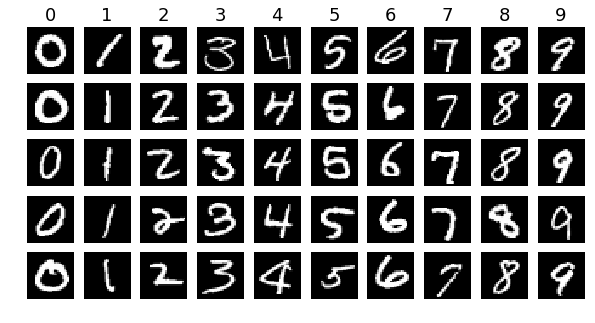

In [4]:
samples = 5
plt.gcf().set_size_inches(10, samples)
for i in range(digit_num):
    digits = train_data.loc[train_data['label'] == i].iloc[:, 1:]
    for j in range(samples):
        plt_idx = i + 1 + j * digit_num 
        plt.subplot(samples, digit_num, plt_idx)
        plt.imshow(digits.iloc[j].values.reshape(28, 28), cmap='gray')
        plt.axis("off")
        if j == 0:
            plt.title(i, fontsize=18)

## Prior Possibilities

manual: [0.09838095238095237, 0.11152380952380953, 0.09945238095238096, 0.1035952380952381, 0.09695238095238096, 0.09035714285714286, 0.0985, 0.10478571428571429, 0.09673809523809523, 0.09971428571428571]


(array([0.09838095, 0.11152381, 0.09945238, 0.10359524, 0.09695238,
        0.09035714, 0.0985    , 0.10478571, 0.0967381 , 0.09971429]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

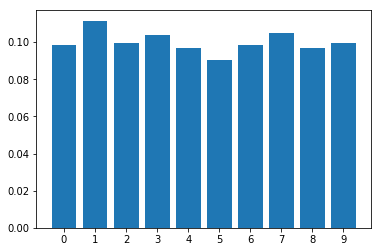

In [5]:
# Manual
prior_possibilities = [len(train_data.loc[train_data['label'] == i]) / train_data.shape[0] for i in range(digit_num)]
print("manual:", prior_possibilities)

# Plot
plt.xticks(range(digit_num))
plt.hist(train_data['label'], bins=range(digit_num + 1), density=True, align='left', rwidth=0.8)

## L2 Distance Between Pixel Values

CPU times: user 10.8 s, sys: 1.16 s, total: 12 s
Wall time: 12 s


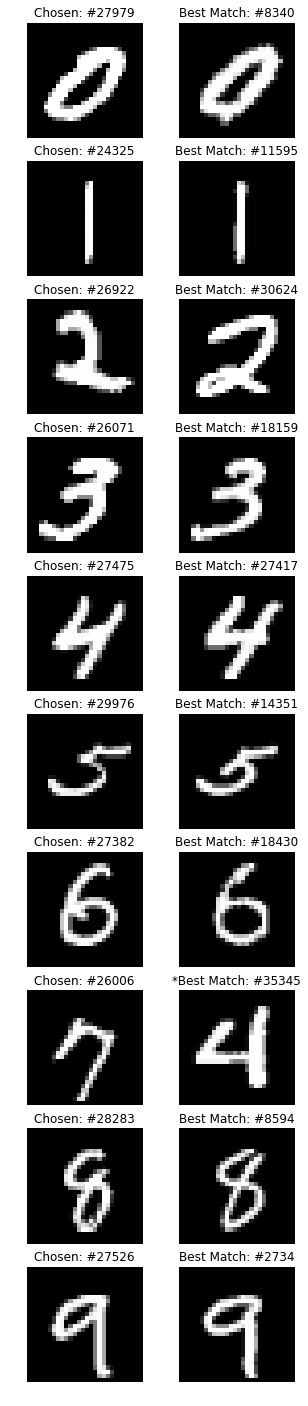

In [6]:
%%time

plt.gcf().set_size_inches(5, 25)

def get_L2_dist_m2o(Xs, Y):
    return np.sqrt(np.square(Xs).sum(axis = 1) - 2 * np.dot(Xs, Y.T) + np.square(Y).sum())


def get_L2_dist_m2m(Xs, Ys):
    """
      X [3,4],     Y [0,0],
        [5,12]       [1,1]

      X^2 [9, 16],  sum(axis=1) [25,  25]     [X1, X1,
          [25,144]     tile      169, 169]     X2, X2]

      Y^2 [0, 0],   sum(axis=1)   [0, 2]       [Y1, Y2],
          [1, 1]       tile        0, 2]        Y1, Y2 

      2(X dot Y.T)                [0 14],      [X1Y1, X1Y2],
                                  [0 34]       [X2Y1, X2Y2]

      result     [25+0-0=25,    25+2-14=13],   [X1Y1, X1Y2], 
                 [169+0-0=169, 169+2-34=137]   [X2Y1, X2Y2]             
    """
    sum_X_sqr = np.square(Xs).sum(axis = 1)
    matrix_X_sqr = np.tile(sum_X_sqr, (sum_X_sqr.shape[0], 1)).T
    
    sum_Y_sqr = np.square(Ys).sum(axis = 1)
    matrix_Y_sqr = np.tile(sum_Y_sqr, (sum_Y_sqr.shape[0], 1))
    
    return np.sqrt(matrix_X_sqr - 2 * np.dot(Xs, Ys.T) + matrix_Y_sqr)



nth = 2716 #random.randint(0, 3000)
for i in range(digit_num):
    # calculate
    data_of_digit = train_data[train_data['label'] == i]
    chosen_idx = data_of_digit.index[nth]
    chosen_digit = data_of_digit.iloc[nth, 1:].values
    L2_result = get_L2_dist_m2o(train_data.iloc[:, 1:].values, chosen_digit)
    best_match_idx = np.argmin(L2_result[L2_result != 0])

    # plot chosen
    plt.subplot(digit_num, 2, i * 2 + 1)
    plt.imshow(chosen_digit.reshape(28, 28), cmap='gray')
    plt.axis("off") 
    plt.title("Chosen: #" + str(chosen_idx), fontsize=12)

    # plot best match
    plt.subplot(digit_num, 2, i * 2 + 2)
    plt.imshow(train_data.iloc[best_match_idx, 1:].values.reshape(28, 28), cmap='gray')
    plt.axis("off")
    asterisk = ""
    if train_data.iloc[chosen_idx][0] != train_data.iloc[best_match_idx][0]:
        asterisk = "*"
    plt.title(asterisk + "Best Match: #" + str(best_match_idx), fontsize=12)
    
plt.show

## Binary Comparision Between 0 and 1 (L2 Distance)

In [12]:
%%time

def get_comparision_result(data1, data2):
    result = []
    for i in range(len(data1)):
        result.extend(get_L2_dist_m2o(data2[i:], data1[i]))
    return result

data_0 = train_data[train_data['label'] == 0].iloc[:, 1:].values
data_1 = train_data[train_data['label'] == 1].iloc[:, 1:].values

_0to0 = get_comparision_result(data_0, data_0)
_0to1 = get_comparision_result(data_0, data_1)
_1to1 = get_comparision_result(data_1, data_1)

CPU times: user 9min 21s, sys: 24.1 s, total: 9min 45s
Wall time: 9min 46s


### Historgram

<function matplotlib.pyplot.show(*args, **kw)>

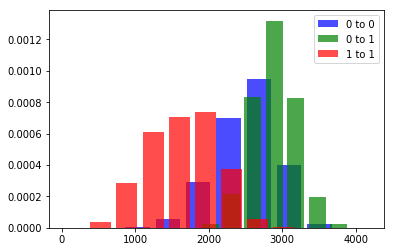

In [13]:
plt.hist(_0to0, density=1, rwidth=0.8, color='blue', alpha=0.7, label="0 to 0")
plt.hist(_0to1, density=1, rwidth=0.8, color='green', alpha=0.7, label="0 to 1")
plt.hist(_1to1, density=1, rwidth=0.8, color='red', alpha=0.7, label="1 to 1")
plt.legend()
plt.show

### ROC Curve and Equal Error Rate

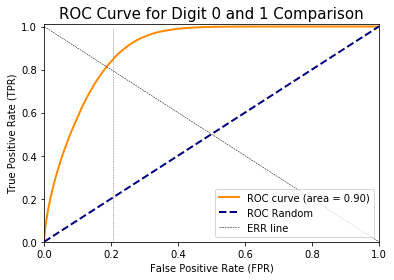

In [14]:
from sklearn import metrics

# label 1 = Negative (shorter distance), label 0 = Positive (longer distance)
labels = [1] * (len(_0to0) + len(_1to1))
labels.extend([0] * len(_0to1))
scores = []
scores.extend(_0to0)
scores.extend(_1to1)
scores.extend(_0to1)
fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=0)

# plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="ROC Random")
plt.plot([0, 1], [1, 0], color='black', lw=0.5, linestyle='--', label="ERR line")
plt.plot([0.205, 0.205], [0, 1], color='grey', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Digit 0 and 1 Comparison', fontsize=15)
plt.legend(loc="lower right")
plt.show()

## kNN on Digit Recognization

### kNN Classifier Implementation

In [15]:
class kNN:
    def __init__(self):
        pass

    
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        
        
    def predict(self, X, k=1):
        distances = self.compute_distances(X)
        n = distances.shape[0]
        y_pred = np.zeros(n).astype(int)
        
        for i in range(n):
            labels = self.y_train[np.argsort(distances[i, :])].flatten()
            k_closest_y = labels[:k]
            y_pred[i] = self.judgeFromNeighbors(k_closest_y)
        
        return y_pred
    
        
    # use L2 distance
    def compute_distances(self, X):
        sum_test_sqr = np.square(X).sum(axis = 1)
        sum_train_sqr = np.square(self.X_train).sum(axis = 1)
        
        matrix_test_sqr = np.tile(sum_test_sqr, (sum_train_sqr.shape[0], 1)).T
        matrix_train_sqr = np.tile(sum_train_sqr, (sum_train_sqr.shape[0], 1))
    
        return np.sqrt(matrix_test_sqr - 2 * np.dot(X, self.X_train.T) + sum_train_sqr)
    
    
    def judgeFromNeighbors(self, neighbors):
        count = {}
        max_count = 0
        max_label = 0
        for n in neighbors:
            if n not in count:
                count[n] = 1
            else:
                count[n] += 1
            
            if count[n] > max_count:
                max_count = count[n]
                max_label = n
        
        return max_label
    

def run_batch_kNN(classifier, k, batch_size, X_test):
    batch_num = int(len(X_test) / 1000) + 1

    result = []
    for i in range(batch_num):
        print("Computing batch " + str(i + 1) + "/" + str(batch_num) + "...")
        start = time.time()
        result.extend(classifier.predict(X_test[i * batch_size : (i + 1) * batch_size], k))
        end = time.time()
        print("==> Completed in " + format(end - start, '.2f') + "s" )
    
    return result

### Randomly split training data into two halves.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, 1:].values, \
                                                    train_data.iloc[:, :1].values, \
                                                    test_size=0.5, random_state=37)

### Run kNN Classifier on Training Data in Batch 

In [19]:
%%time

classifier = kNN()
classifier.train(X_train, y_train)
y_pred = run_batch_kNN(classifier, 5, 1000, X_test)

Computing batch 1/22...
==> Completed in 18.32s
Computing batch 2/22...
==> Completed in 18.08s
Computing batch 3/22...
==> Completed in 18.35s
Computing batch 4/22...
==> Completed in 18.08s
Computing batch 5/22...
==> Completed in 18.04s
Computing batch 6/22...
==> Completed in 18.01s
Computing batch 7/22...
==> Completed in 18.03s
Computing batch 8/22...
==> Completed in 18.82s
Computing batch 9/22...
==> Completed in 18.43s
Computing batch 10/22...
==> Completed in 18.25s
Computing batch 11/22...
==> Completed in 18.01s
Computing batch 12/22...
==> Completed in 18.75s
Computing batch 13/22...
==> Completed in 18.20s
Computing batch 14/22...
==> Completed in 18.08s
Computing batch 15/22...
==> Completed in 18.36s
Computing batch 16/22...
==> Completed in 19.30s
Computing batch 17/22...
==> Completed in 18.03s
Computing batch 18/22...
==> Completed in 18.05s
Computing batch 19/22...
==> Completed in 18.44s
Computing batch 20/22...
==> Completed in 18.09s
Computing batch 21/22...
==> 

### Confusion Matrix

<function matplotlib.pyplot.show(*args, **kw)>

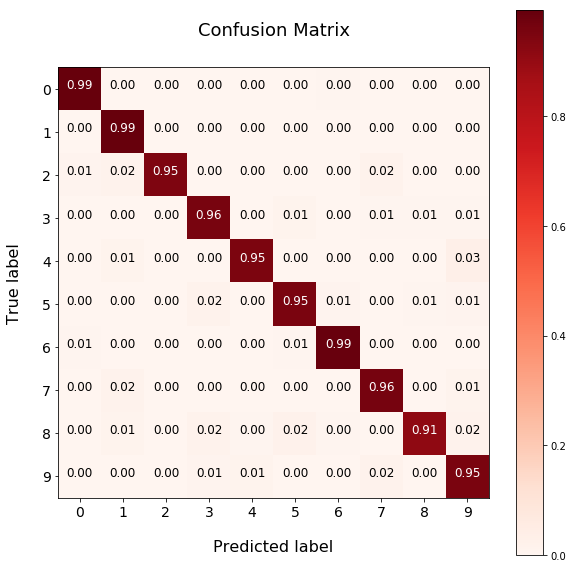

In [20]:
from sklearn.metrics import confusion_matrix

# calculate
confu_matrix = confusion_matrix(y_test[:len(y_pred)], y_pred)

# normalize
confu_matrix = confu_matrix.astype('float') / confu_matrix.sum(axis=1)[:, np.newaxis]

# plot
plt.gcf().set_size_inches(8, 8)
img = plt.imshow(confu_matrix, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix", fontsize=18, y=1.06)

# cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img)

tick_marks = np.arange(digit_num)
plt.xticks(tick_marks, tick_marks, fontsize = 14)
plt.yticks(tick_marks, tick_marks, fontsize = 14)

thresh = confu_matrix.max() / 2.
for i, j in itertools.product(range(confu_matrix.shape[0]), range(confu_matrix.shape[1])):
    plt.text(j, i, format(confu_matrix[i, j], '.2f'), fontsize=12, \
             horizontalalignment="center",  \
             color="white" if confu_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label', fontsize=16, labelpad=20)
plt.xlabel('Predicted label', fontsize=16, labelpad=20)

plt.show

### Run kNN Classifier on Test Data and Export to CSV file

In [21]:
test_data = pd.read_csv('data/test.csv')
display(test_data)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time

real_classifier = kNN()
real_classifier.train(train_data.iloc[:, 1:].values, train_data.iloc[:, :1].values)
real_pred_y = run_batch_kNN(real_classifier, 5, 1000, test_data.values[:])

submit_df = pd.DataFrame(data={"ImageId": np.arange(1, len(real_pred_y) + 1), "Label": real_pred_y} )
submit_df.to_csv("submission/submission_" + time.strftime('%m%d_%H%M%S') + ".csv", sep=",", index=False)
display(submit_df)

Computing batch 1/29...
